Pour toute opération de politique d'un `crdt.dag.DAG`, `DAG.estValide` doit permettre de retourner sa validité (resp. invalidité), c'est-à-dire un statut de prise en compte (resp. exclusion) de l'opération dans l'évaluation de la politique d'accès. Ce statut permet de distinguer les opérations dont l'effet est acceptable ou inacceptable selon la politique d'accès évaluée à terme. On teste la validité de notre algorithme dans [gitlab.inria.fr/coast-team/crdt-ac/tests](https://gitlab.inria.fr/coast-team/crdt-ac/tests/-/blob/main/02-tests-estValide.ipynb), sur les scénarios[^1] qui suivent.

[^1]: les scénarios reprennent les noms utilisés page 12 du rapport [03-mecanismes](https://gitlab.inria.fr/coast-team/crdt-ac/notes/-/blob/main/03-mecanismes.tex)

On commence par importer la `crdt.dag.DAG` qui nous permet de représenter un droit pour un site, et les opérations le modifiant.

In [1]:
#| hide
import sys
sys.path.insert(0, '/home/rigelk/Code/thesis-implementation/')
from crdt.dag import DAG # classe gérant les DAG
from crdt.console import test_combinations # batterie de tests

### (b) conflits (résolution descendante)

On teste ici la résolution de conflits où une opération de niveau _n_ prévaut sur une opération concurrente de niveau _n + 1_.

::: {.callout-note appearance="simple"}
Certaines combinaisons d'opérations menent à des états de transition invalides (en rouge). Tant que le dernier état converge vers un état conforme à ce qui est attendu (vert), cela veut dire que le modèle d'évaluation converge pour cette combinaison.
:::

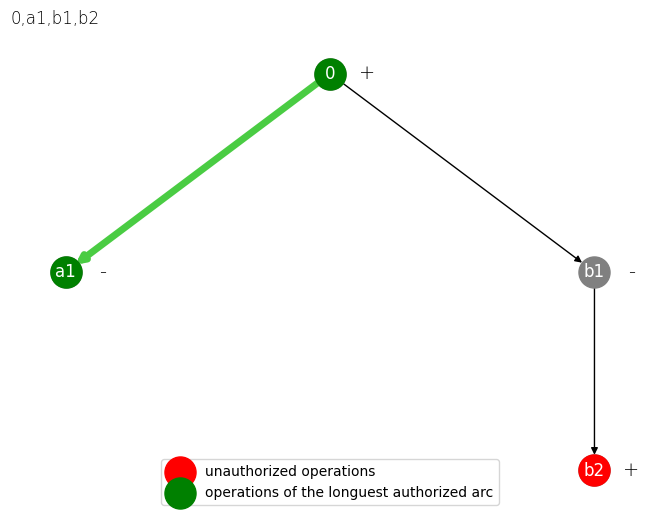

           Evaluation after each reception (scenario #0: 0,a1,b1,b2)            
                                                                                
╭────── STEP 1/3 ───────╮ ╭────── STEP 2/3 ───────╮ ╭───── #0 FINAL STATE ─────╮
│                       │ │                       │ │                          │
│   a1     authorized   │ │   a1     authorized   │ │   a1     authorized ✅   │
│                       │ │   b1     authorized   │ │   b1     authorized ✅   │
╰──────── 0,a1 ─────────╯ │                       │ │   b2   unauthorized ✅   │
                          ╰─────── 0,a1,b1 ───────╯ │                          │
                                                    ╰─────── 0,a1,b1,b2 ───────╯

           Evaluation after each reception (scenario #2: 0,b1,a1,b2)            
                                                                                
╭────── STEP 1/3 ───────╮ ╭────── STEP 2/3 ───────╮ ╭───── #2 FINAL STATE ─────╮
│                       │ │                       │ │                          │
│   b1     authorized   │ │   b1     authorized   │ │   b1     authorized ✅   │
│                       │ │   a1     authorized   │ │   a1     authorized ✅   │
╰──────── 0,b1 ─────────╯ │                       │ │   b2   unauthorized ✅   │
                          ╰─────── 0,b1,a1 ───────╯ │                          │
                                                    ╰─────── 0,b1,a1,b2 ───────╯

           Evaluation after each reception (scenario #3: 0,b1,b2,a1)            
                                                                                
╭────── STEP 1/3 ───────╮ ╭────── STEP 2/3 ───────╮ ╭───── #3 FINAL STATE ─────╮
│                       │ │                       │ │                          │
│   b1     authorized   │ │   b1     authorized   │ │   b1     authorized ✅   │
│                       │ │   b2     authorized   │ │   b2   unauthorized ✅   │
╰──────── 0,b1 ─────────╯ │                       │ │   a1     authorized ✅   │
                          ╰─────── 0,b1,b2 ───────╯ │                          │
                                                    ╰─────── 0,b1,b2,a1 ───────╯

In [2]:
G_b = DAG()
G_b.add_op('a1', ['0'])
G_b.add_op('b1', ['0'])
G_b.add_op('b2', ['b1'])
G_b.draw()

test_combinations([
  ('a1', ('C', 'write'), ['0'], True),
  ('b1', ('C', 'write'), ['0'], True),
  ('b2', ('C', 'write'), ['b1'], False),
], detail=True)

L'étape 2/3 de la variante 3 ne correspond pas à l'état final attendu (indiqué en orange), 
on diverge donc momentanément de l'état désiré. Tant que l'état final
converge sur la même évaluation que prévu, l'agorithme est correct.

### (c) conflits (résolution ascendante)

On teste ici la résolution de conflits où une opération de niveau _n + 1_ prévaut sur une opération concurrente de niveau _n_. On le fait ici en changeant le critère discrétionnaire d'ordre de priorité des opérations. Jusqu'ici, on a implicitement priorisé les opérations suivant l'ordre lexicographique de leurs sites émetteurs. On peut pourtant décider d'un autre critère, arbitraire, tant qu'il est déterministe et partagé par chaque site.

Ici, on explicite juste un ordre différent, qui doit se refléter dans les résultats.

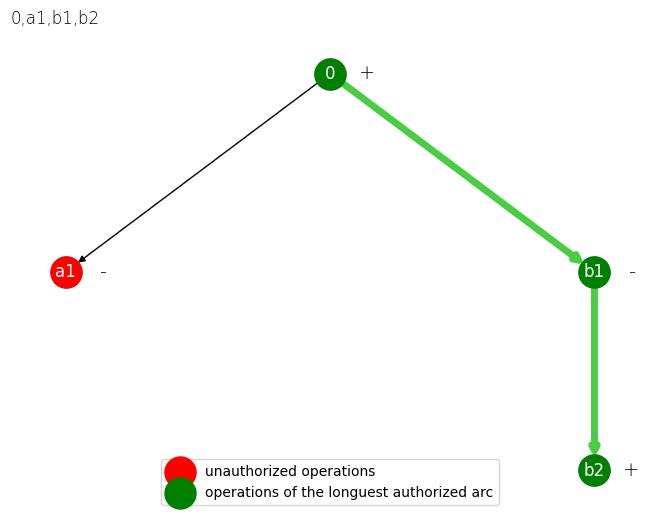

           Evaluation after each reception (scenario #0: 0,a1,b1,b2)            
                                                                                
╭────── STEP 1/3 ───────╮ ╭────── STEP 2/3 ───────╮ ╭───── #0 FINAL STATE ─────╮
│                       │ │                       │ │                          │
│   a1     authorized   │ │   a1     authorized   │ │   a1   unauthorized ✅   │
│                       │ │   b1     authorized   │ │   b1     authorized ✅   │
╰──────── 0,a1 ─────────╯ │                       │ │   b2     authorized ✅   │
                          ╰─────── 0,a1,b1 ───────╯ │                          │
                                                    ╰─────── 0,a1,b1,b2 ───────╯

           Evaluation after each reception (scenario #2: 0,b1,a1,b2)            
                                                                                
╭────── STEP 1/3 ───────╮ ╭────── STEP 2/3 ───────╮ ╭───── #2 FINAL STATE ─────╮
│                       │ │                       │ │                          │
│   b1     authorized   │ │   b1     authorized   │ │   b1     authorized ✅   │
│                       │ │   a1     authorized   │ │   a1   unauthorized ✅   │
╰──────── 0,b1 ─────────╯ │                       │ │   b2     authorized ✅   │
                          ╰─────── 0,b1,a1 ───────╯ │                          │
                                                    ╰─────── 0,b1,a1,b2 ───────╯

           Evaluation after each reception (scenario #3: 0,b1,b2,a1)            
                                                                                
╭────── STEP 1/3 ───────╮ ╭────── STEP 2/3 ───────╮ ╭───── #3 FINAL STATE ─────╮
│                       │ │                       │ │                          │
│   b1     authorized   │ │   b1     authorized   │ │   b1     authorized ✅   │
│                       │ │   b2     authorized   │ │   b2     authorized ✅   │
╰──────── 0,b1 ─────────╯ │                       │ │   a1   unauthorized ✅   │
                          ╰─────── 0,b1,b2 ───────╯ │                          │
                                                    ╰─────── 0,b1,b2,a1 ───────╯

In [3]:
G_c = DAG()
G_c.order = ['C', 'B', 'A']
G_c.add_op('a1', ['0'])
G_c.add_op('b1', ['0'])
G_c.add_op('b2', ['b1'])
G_c.draw()

test_combinations([
  ('a1', ('C', 'write'), ['0'], False),
  ('b1', ('C', 'write'), ['0'], True),
  ('b2', ('C', 'write'), ['b1'], True)
], order=['C', 'B', 'A'], detail=True)

### (d) conflits sur conflits

On teste ici une situation où l'opération priorisée est elle-même en conflit avec une troisième opération qui prend la priorité. Que faire dans ce cas ? Rétablir la première opération dont le conflit peut désormais être ignoré ? Ou bien la garder invalide ?

En pratique, cette situation ne se pose pas, comme l'illustre l'exemple suivant. En effet, pour qu'une troisième opération soit en conflit avec la seconde, elle doit aussi être en conflit avec l'opération parente de la première, rendant celle-ci invalide par la même occasion. Pour que la première et la troisième opération soient valides en même temps, il faudrait changer les règles de mise en conflit de deux opérations (qui sont nécessite actuellement une concurrence et un niveau de parité différente entre les deux opérations).

::: {.callout-note apppearance="simple"}
Étant donné le nombre élevé de combinaisons, on ne liste que les dernières étapes de diffusion de chaque combinaison.
:::

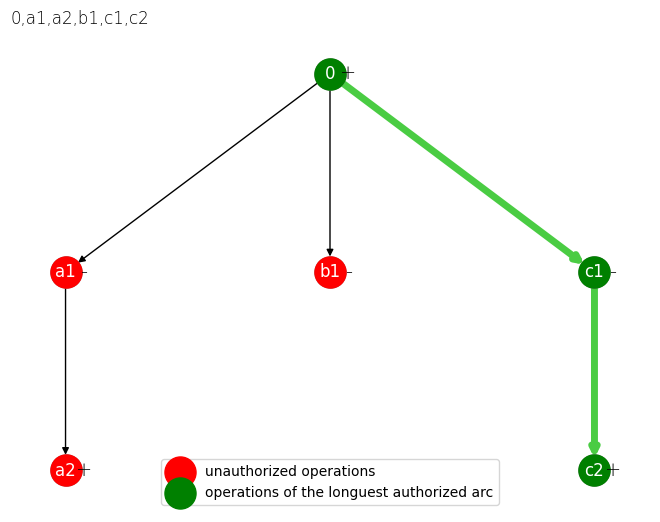

                   Final evaluation of each scenario (30 valides/30 correctes/120 permutations)                    
                                                                                                                   
╭───── #0 FINAL STATE ─────╮ ╭───── #2 FINAL STATE ─────╮ ╭───── #3 FINAL STATE ─────╮ ╭───── #6 FINAL STATE ─────╮
│                          │ │                          │ │                          │ │                          │
│   a1   unauthorized ✅   │ │   a1   unauthorized ✅   │ │   a1   unauthorized ✅   │ │   a1   unauthorized ✅   │
│   a2   unauthorized ✅   │ │   a2   unauthorized ✅   │ │   a2   unauthorized ✅   │ │   b1   unauthorized ✅   │
│   b1   unauthorized ✅   │ │   c1     authorized ✅   │ │   c1     authorized ✅   │ │   a2   unauthorized ✅   │
│   c1     authorized ✅   │ │   b1   unauthorized ✅   │ │   c2     authorized ✅   │ │   c1     authorized ✅   │
│   c2     authorized ✅   │ │   c2     authorized ✅   │ │   b1   unauthorized ✅   │ │   c2     authorized ✅   │
│                          │ │                          │ │                          │ │                          │
╰──── 0,a1,a2,b1,c1,c2 ────╯ ╰──── 0,a1,a2,c1,b1,c2 ────╯ ╰──── 0,a1,a2,c1,c2,b1 ────╯ ╰──── 0,a1,b1,a2,c1,c2 ────╯
                                                                                                                   
╭───── #8 FINAL STATE ─────╮ ╭───── #9 FINAL STATE ─────╮ ╭──── #12 FINAL STATE ─────╮ ╭──── #13 FINAL STATE ─────╮
│                          │ │                          │ │                          │ │                          │
│   a1   unauthorized ✅   │ │   a1   unauthorized ✅   │ │   a1   unauthorized ✅   │ │   a1   unauthorized ✅   │
│   b1   unauthorized ✅   │ │   b1   unauthorized ✅   │ │   c1     authorized ✅   │ │   c1     authorized ✅   │
│   c1     authorized ✅   │ │   c1     authorized ✅   │ │   a2   unauthorized ✅   │ │   a2   unauthorized ✅   │
│   a2   unauthorized ✅   │ │   c2     authorized ✅   │ │   b1   unauthorized ✅   │ │   c2     authorized ✅   │
│   c2     authorized ✅   │ │   a2   unauthorized ✅   │ │   c2     authorized ✅   │ │   b1   unauthorized ✅   │
│                          │ │                          │ │                          │ │                          │
╰──── 0,a1,b1,c1,a2,c2 ────╯ ╰──── 0,a1,b1,c1,c2,a2 ────╯ ╰──── 0,a1,c1,a2,b1,c2 ────╯ ╰──── 0,a1,c1,a2,c2,b1 ────╯
                                                                                                                   
╭──── #14 FINAL STATE ─────╮ ╭──── #15 FINAL STATE ─────╮ ╭──── #16 FINAL STATE ─────╮ ╭──── #17 FINAL STATE ─────╮
│                          │ │                          │ │                          │ │                          │
│   a1   unauthorized ✅   │ │   a1   unauthorized ✅   │ │   a1   unauthorized ✅   │ │   a1   unauthorized ✅   │
│   c1     authorized ✅   │ │   c1     authorized ✅   │ │   c1     authorized ✅   │ │   c1     authorized ✅   │
│   b1   unauthorized ✅   │ │   b1   unauthorized ✅   │ │   c2     authorized ✅   │ │   c2     authorized ✅   │
│   a2   unauthorized ✅   │ │   c2     authorized ✅   │ │   a2   unauthorized ✅   │ │   b1   unauthorized ✅   │
│   c2     authorized ✅   │ │   a2   unauthorized ✅   │ │   b1   unauthorized ✅   │ │   a2   unauthorized ✅   │
│                          │ │                          │ │                          │ │                          │
╰──── 0,a1,c1,b1,a2,c2 ────╯ ╰──── 0,a1,c1,b1,c2,a2 ────╯ ╰──── 0,a1,c1,c2,a2,b1 ────╯ ╰──── 0,a1,c1,c2,b1,a2 ────╯
                                                                                                                   
╭──── #48 FINAL STATE ─────╮ ╭──── #50 FINAL STATE ─────╮ ╭──── #51 FINAL STATE ─────╮ ╭──── #60 FINAL STATE ─────╮
│                          │ │                          │ │                          │ │                          │
│   b1   unauthorized ✅   │ │   b1   unauthorized ✅   │ │   b1   unauthorized ✅   │ │   b1   unauthorized ✅   │
│   

In [4]:
G_d = DAG()
G_d.order = ['C', 'B', 'A']
G_d.add_op('a1', ['0'])
G_d.add_op('a2', ['a1'])
G_d.add_op('b1', ['0'])
G_d.add_op('c1', ['0'])
G_d.add_op('c2', ['c1'])
G_d.draw()

test_combinations([
  ('a1', ('D', 'write'), ['0'], False),
  ('a2', ('D', 'write'), ['a1'], False),
  ('b1', ('D', 'write'), ['0'], False),
  ('c1', ('D', 'write'), ['0'], True),
  ('c2', ('D', 'write'), ['c1'], True)
], order=['C', 'B', 'A'])

### (e) conflit avec le tuple d'admin

Jusqu'ici on testait tout dans le cadre limité d'un DAG représentant un tuple d'accès. Peu nous importaient le signe d'une opération (retrait ou ajout du droit) ou le site qu'elle cible. Mais d'autres conflits existent, notamment les opérations retirant au site émetteur d'une opération le droit d'_admin_ le rendant capable de l'émettre. On contruit ici un tel exemple, similaire aux cas (b) et (c) précédents, adjoints d'une tuple d'admin retirant le droit d'émettre une des opérations.

La représentation montre deux chemins valides : un pour chaque tuple d'accès.

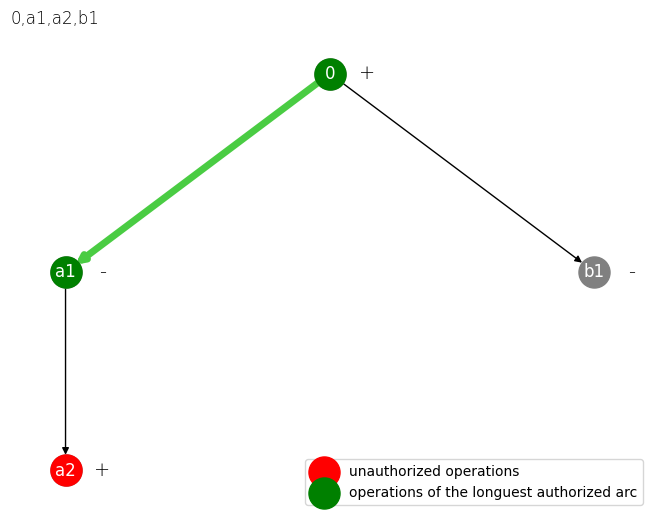

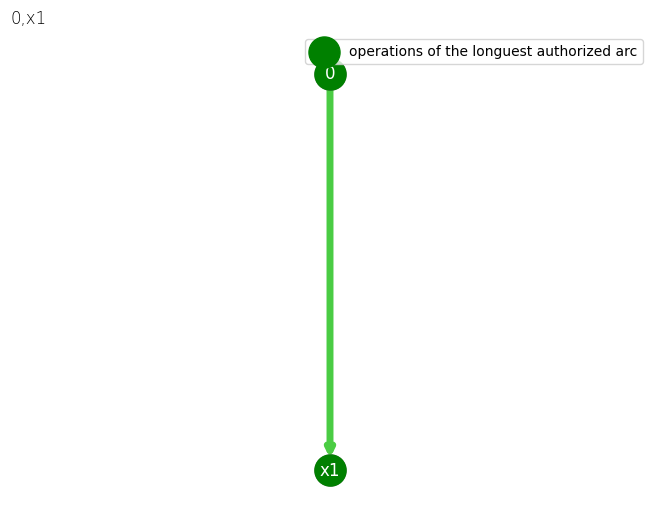

In [5]:
#| column: screen-inset
#| layout-nrow: 1

from crdt.dag import DAG
from crdt.crdt import Rights

order = ['X', 'B', 'A']

G_e__write_A = DAG()
G_e__write_A.order = order
G_e__write_A.add_op('a1', ['0'])
G_e__write_A.add_op('a2', ['a1'])
G_e__write_A.add_op('b1', ['0'])

G_e__admin_B = DAG()
G_e__admin_B.order = order
G_e__admin_B.add_op('x1', ['0'], last='0') # dernière opération conue de B par X au moment de lui retirer le droit = état initial

R_e = Rights()
R_e[('C', 'write')] = G_e__write_A
R_e[('B', 'admin')] = G_e__admin_B

R_e.draw()

In [6]:
test_combinations([
  ('a1', ('C', 'write'), ['0'], True), # type: ignore
  ('a2', ('C', 'write'), ['a1'], False),
  ('b1', ('C', 'write'), ['0'], False),
  ('x1', ('B', 'admin'), ['0'], True)
], order=order)

                    Final evaluation of each scenario (0 valides/12 correctes/24 permutations)                     
                                                                                                                   
╭───── #0 FINAL STATE ─────╮ ╭───── #1 FINAL STATE ─────╮ ╭───── #2 FINAL STATE ─────╮ ╭───── #3 FINAL STATE ─────╮
│                          │ │                          │ │                          │ │                          │
│   a1     authorized ✅   │ │   a1     authorized ✅   │ │   a1     authorized ✅   │ │   a1     authorized ✅   │
│   a2   unauthorized ✅   │ │   a2   unauthorized ✅   │ │   b1     authorized ❌   │ │   b1     authorized ❌   │
│   b1     authorized ❌   │ │   x1     authorized ✅   │ │   a2   unauthorized ✅   │ │   x1     authorized ✅   │
│   x1     authorized ✅   │ │   b1     authorized ❌   │ │   x1     authorized ✅   │ │   a2   unauthorized ✅   │
│                          │ │                          │ │                          │ │                          │
╰───── 0,a1,a2,b1,x1 ──────╯ ╰───── 0,a1,a2,x1,b1 ──────╯ ╰───── 0,a1,b1,a2,x1 ──────╯ ╰───── 0,a1,b1,x1,a2 ──────╯
                                                                                                                   
╭───── #4 FINAL STATE ─────╮ ╭───── #5 FINAL STATE ─────╮ ╭──── #12 FINAL STATE ─────╮ ╭──── #13 FINAL STATE ─────╮
│                          │ │                          │ │                          │ │                          │
│   a1     authorized ✅   │ │   a1     authorized ✅   │ │   b1     authorized ❌   │ │   b1     authorized ❌   │
│   x1     authorized ✅   │ │   x1     authorized ✅   │ │   a1     authorized ✅   │ │   a1     authorized ✅   │
│   a2   unauthorized ✅   │ │   b1     authorized ❌   │ │   a2   unauthorized ✅   │ │   x1     authorized ✅   │
│   b1     authorized ❌   │ │   a2   unauthorized ✅   │ │   x1     authorized ✅   │ │   a2   unauthorized ✅   │
│                          │ │                          │ │                          │ │                          │
╰───── 0,a1,x1,a2,b1 ──────╯ ╰───── 0,a1,x1,b1,a2 ──────╯ ╰───── 0,b1,a1,a2,x1 ──────╯ ╰───── 0,b1,a1,x1,a2 ──────╯
                                                                                                                   
╭──── #16 FINAL STATE ─────╮ ╭──── #18 FINAL STATE ─────╮ ╭──── #19 FINAL STATE ─────╮ ╭──── #22 FINAL STATE ─────╮
│                          │ │                          │ │                          │ │                          │
│   b1     authorized ❌   │ │   x1     authorized ✅   │ │   x1     authorized ✅   │ │   x1     authorized ✅   │
│   x1     authorized ✅   │ │   a1     authorized ✅   │ │   a1     authorized ✅   │ │   b1     authorized ❌   │
│   a1     authorized ✅   │ │   a2   unauthorized ✅   │ │   b1     authorized ❌   │ │   a1     authorized ✅   │
│   a2   unauthorized ✅   │ │   b1     authorized ❌   │ │   a2   unauthorized ✅   │ │   a2   unauthorized ✅   │
│                          │ │                          │ │                          │ │                          │
╰───── 0,b1,x1,a1,a2 ──────╯ ╰───── 0,x1,a1,a2,b1 ──────╯ ╰───── 0,x1,a1,b1,a2 ──────╯ ╰───── 0,x1,b1,a1,a2 ──────╯

### (g) concurrence sur 1-3 niveaux

Vérifie que l'algorithme fonctionne avec des niveaux plus importants.

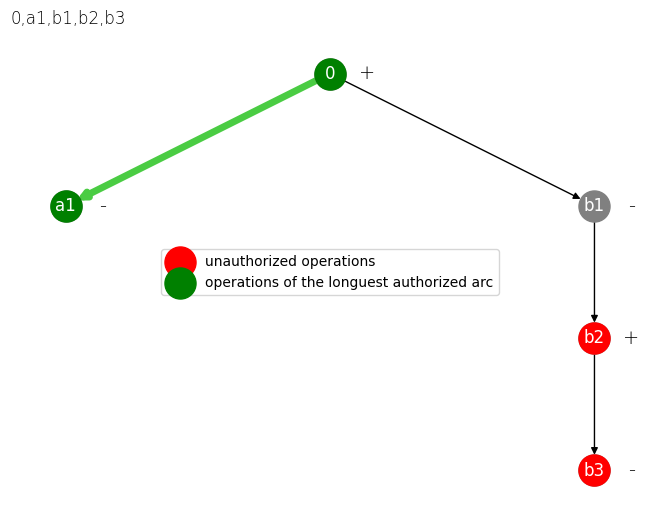

                       Evaluation after each reception (scenario #0: 0,a1,b1,b2,b3)                       
                                                                                                          
╭────── STEP 1/4 ───────╮ ╭────── STEP 2/4 ───────╮ ╭────── STEP 3/4 ───────╮ ╭───── #0 FINAL STATE ─────╮
│                       │ │                       │ │                       │ │                          │
│   a1     authorized   │ │   a1     authorized   │ │   a1     authorized   │ │   a1     authorized ✅   │
│                       │ │   b1     authorized   │ │   b1     authorized   │ │   b1     authorized ✅   │
╰──────── 0,a1 ─────────╯ │                       │ │   b2   unauthorized   │ │   b2   unauthorized ✅   │
                          ╰─────── 0,a1,b1 ───────╯ │                       │ │   b3   unauthorized ✅   │
                                                    ╰───── 0,a1,b1,b2 ──────╯ │                          │
                                                                              ╰───── 0,a1,b1,b2,b3 ──────╯

                       Evaluation after each reception (scenario #6: 0,b1,a1,b2,b3)                       
                                                                                                          
╭────── STEP 1/4 ───────╮ ╭────── STEP 2/4 ───────╮ ╭────── STEP 3/4 ───────╮ ╭───── #6 FINAL STATE ─────╮
│                       │ │                       │ │                       │ │                          │
│   b1     authorized   │ │   b1     authorized   │ │   b1     authorized   │ │   b1     authorized ✅   │
│                       │ │   a1     authorized   │ │   a1     authorized   │ │   a1     authorized ✅   │
╰──────── 0,b1 ─────────╯ │                       │ │   b2   unauthorized   │ │   b2   unauthorized ✅   │
                          ╰─────── 0,b1,a1 ───────╯ │                       │ │   b3   unauthorized ✅   │
                                                    ╰───── 0,b1,a1,b2 ──────╯ │                          │
                                                                              ╰───── 0,b1,a1,b2,b3 ──────╯

                       Evaluation after each reception (scenario #8: 0,b1,b2,a1,b3)                       
                                                                                                          
╭────── STEP 1/4 ───────╮ ╭────── STEP 2/4 ───────╮ ╭────── STEP 3/4 ───────╮ ╭───── #8 FINAL STATE ─────╮
│                       │ │                       │ │                       │ │                          │
│   b1     authorized   │ │   b1     authorized   │ │   b1     authorized   │ │   b1     authorized ✅   │
│                       │ │   b2     authorized   │ │   b2   unauthorized   │ │   b2   unauthorized ✅   │
╰──────── 0,b1 ─────────╯ │                       │ │   a1     authorized   │ │   a1     authorized ✅   │
                          ╰─────── 0,b1,b2 ───────╯ │                       │ │   b3   unauthorized ✅   │
                                                    ╰───── 0,b1,b2,a1 ──────╯ │                          │
                                                                              ╰───── 0,b1,b2,a1,b3 ──────╯

                       Evaluation after each reception (scenario #9: 0,b1,b2,b3,a1)                       
                                                                                                          
╭────── STEP 1/4 ───────╮ ╭────── STEP 2/4 ───────╮ ╭────── STEP 3/4 ───────╮ ╭───── #9 FINAL STATE ─────╮
│                       │ │                       │ │                       │ │                          │
│   b1     authorized   │ │   b1     authorized   │ │   b1     authorized   │ │   b1     authorized ✅   │
│                       │ │   b2     authorized   │ │   b2     authorized   │ │   b2   unauthorized ✅   │
╰──────── 0,b1 ─────────╯ │                       │ │   b3     authorized   │ │   b3   unauthorized ✅   │
                          ╰─────── 0,b1,b2 ───────╯ │                       │ │   a1     authorized ✅   │
                                                    ╰───── 0,b1,b2,b3 ──────╯ │                          │
                                                                              ╰───── 0,b1,b2,b3,a1 ──────╯

In [7]:
G_g = DAG()
G_g.add_op('a1', ['0'])
G_g.add_op('b1', ['0'])
G_g.add_op('b2', ['b1'])
G_g.add_op('b3', ['b2'])
G_g.draw()

test_combinations([
  ('a1', ('C', 'write'), ['0'], True),
  ('b1', ('C', 'write'), ['0'], True),
  ('b2', ('C', 'write'), ['b1'], False),
  ('b3', ('C', 'write'), ['b2'], False),
], detail=True)

### (h) concurrence sur 2-3 niveaux

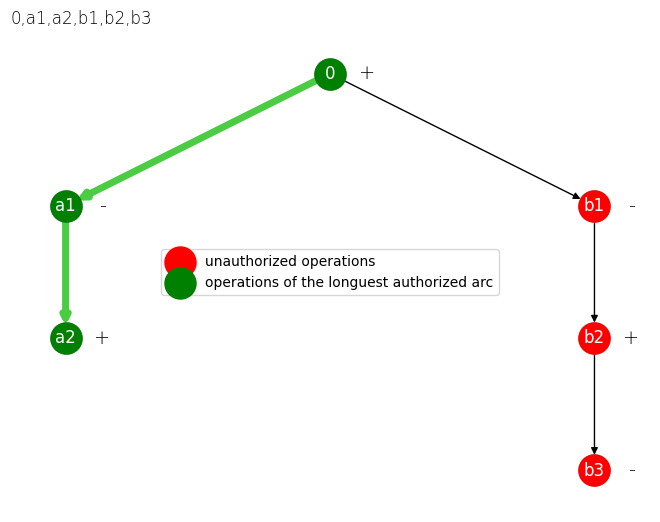

                   Final evaluation of each scenario (10 valides/10 correctes/120 permutations)                    
                                                                                                                   
╭───── #0 FINAL STATE ─────╮ ╭───── #6 FINAL STATE ─────╮ ╭───── #8 FINAL STATE ─────╮ ╭───── #9 FINAL STATE ─────╮
│                          │ │                          │ │                          │ │                          │
│   a1     authorized ✅   │ │   a1     authorized ✅   │ │   a1     authorized ✅   │ │   a1     authorized ✅   │
│   a2     authorized ✅   │ │   b1   unauthorized ✅   │ │   b1   unauthorized ✅   │ │   b1   unauthorized ✅   │
│   b1   unauthorized ✅   │ │   a2     authorized ✅   │ │   b2   unauthorized ✅   │ │   b2   unauthorized ✅   │
│   b2   unauthorized ✅   │ │   b2   unauthorized ✅   │ │   a2     authorized ✅   │ │   b3   unauthorized ✅   │
│   b3   unauthorized ✅   │ │   b3   unauthorized ✅   │ │   b3   unauthorized ✅   │ │   a2     authorized ✅   │
│                          │ │                          │ │                          │ │                          │
╰──── 0,a1,a2,b1,b2,b3 ────╯ ╰──── 0,a1,b1,a2,b2,b3 ────╯ ╰──── 0,a1,b1,b2,a2,b3 ────╯ ╰──── 0,a1,b1,b2,b3,a2 ────╯
                                                                                                                   
╭──── #48 FINAL STATE ─────╮ ╭──── #50 FINAL STATE ─────╮ ╭──── #51 FINAL STATE ─────╮ ╭──── #60 FINAL STATE ─────╮
│                          │ │                          │ │                          │ │                          │
│   b1   unauthorized ✅   │ │   b1   unauthorized ✅   │ │   b1   unauthorized ✅   │ │   b1   unauthorized ✅   │
│   a1     authorized ✅   │ │   a1     authorized ✅   │ │   a1     authorized ✅   │ │   b2   unauthorized ✅   │
│   a2     authorized ✅   │ │   b2   unauthorized ✅   │ │   b2   unauthorized ✅   │ │   a1     authorized ✅   │
│   b2   unauthorized ✅   │ │   a2     authorized ✅   │ │   b3   unauthorized ✅   │ │   a2     authorized ✅   │
│   b3   unauthorized ✅   │ │   b3   unauthorized ✅   │ │   a2     authorized ✅   │ │   b3   unauthorized ✅   │
│                          │ │                          │ │                          │ │                          │
╰──── 0,b1,a1,a2,b2,b3 ────╯ ╰──── 0,b1,a1,b2,a2,b3 ────╯ ╰──── 0,b1,a1,b2,b3,a2 ────╯ ╰──── 0,b1,b2,a1,a2,b3 ────╯
                                                                                                                   
╭──── #61 FINAL STATE ─────╮ ╭──── #64 FINAL STATE ─────╮                                                          
│                          │ │                          │                                                          
│   b1   unauthorized ✅   │ │   b1   unauthorized ✅   │                                                          
│   b2   unauthorized ✅   │ │   b2   unauthorized ✅   │                                                          
│   a1     authorized ✅   │ │   b3   unauthorized ✅   │                                                          
│   b3   unauthorized ✅   │ │   a1     authorized ✅   │                                                          
│   a2     authorized ✅   │ │   a2     authorized ✅   │                                                          
│                          │ │                          │                                                          
╰──── 0,b1,b2,a1,b3,a2 ────╯ ╰──── 0,b1,b2,b3,a1,a2 ────╯

In [8]:
G_h = DAG()
G_h.add_op('a1', ['0'])
G_h.add_op('a2', ['a1'])
G_h.add_op('b1', ['0'])
G_h.add_op('b2', ['b1'])
G_h.add_op('b3', ['b2'])
G_h.draw()

test_combinations([
  ('a1', ('C', 'write'), ['0'], True),
  ('a2', ('C', 'write'), ['a1'], True),
  ('b1', ('C', 'write'), ['0'], False),
  ('b2', ('C', 'write'), ['b1'], False),
  ('b3', ('C', 'write'), ['b2'], False),
])